# Simulating Interest Rate Changes and Liability Hedging
### Implementing the Cox Ingersoll Ross Model for interest rates

We saw in the previous lab that when you look at your financial condition in terms of funding ratio, rather than asset value, even cash can be a risky asset.

We're going to simulate changes in interest rates using the Cox-Ingersoll-Ross model, usually just called the CIR model. It is very similar to what we have already done for generating random stock prices. Instead of a Geometric Brownian Motion, the mean reversion model features parameters to control the speed of mean reversion as well as the long term average rate.

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

where $a$ is the speed of mean reversion and $b$ is the long term mean rate and $\sigma$ is the volatility parameter.

This can be read as describing the change in interest at any point of time as a multiple of the distance of the current rate from it's long term mean plus a random value that depends on the volatility parameter.

Thus, we can start at some rate $r_0$ and generate a sequence of rates over time using the change in rate defined by the stochastic differential equation above. If we eliminate the ${\sqrt  {r_{t}}}$ term we get the simpler Vasicek model, but the CIR model eliminates the possibility of negative interest rates by shutting down the volatility term as interest rates approach zero. 

### Short Rate vs Annualized Rate

One final piece of math we'll need is that the interest rate being described here is the "instantaneous" or "short rate" ... we will often want to think about interest rates as annualized rates, which means that the instantaneous rate needs to be compounded into an annual rate as follows:

$$ 1 + r_{annual} = e^{r_{inst}} $$

### Quick Explanation of Short Rate vs Annual Rate

The distinction between the instantaneous rate and the annualized rate is subtle if you have never had an opportunity to think about it, but is best understood in terms of an example:

Let's consider the growth of a dollar over a year, if the rate of interest is 100%.

To answer the question about what that will grow to at the end of the year, we'll need to answer a second question, which is how often will that interest be paid?

If it's paid just once at the end of the year, the answer is easy. The dollar grows to 2 dollars (one dollar in principle and another dollar in interest).

In [1]:
1 + 1*1

2

Now assume that I insist that you pay interest two times a year. i.e. I ask that the interest is compounded more frequently, at a shorter interval than just once a year, and instead it is compounded after every six months. That means, that at the end of 6 months, I pay out one half of the interest (50 cents). However, I now have \$1.50 for the remaining 6 months, and so the total value at the end of the year is the principal plus interest for the first period (50 cents) plus the interest for the second period which is one half of 1.50: 

In [2]:
1 + 1*.5 + 1.5*.5

2.25

Now let's try compounding it at an even shorter rate of once every 3 months, i.e. 4 times a year. We'd get:

In [3]:
1 + (1)*.25 + (1 + (1)*.25)*.25 + (1 + (1)*.25 + (1 + (1)*.25)*.25)*.25 + (1 + (1)*.25 + (1 + (1)*.25)*.25 + (1 + (1)*.25 + (1 + (1)*.25)*.25)*.25)*.25

2.44140625

In general, if we compound every 1/N of a year (i.e. N times a year) we get:

$$\left(1+\frac{r}{N}\right)^N$$


In [4]:
(1+1/2)**2

2.25

In [5]:
(1+1/4)**4

2.44140625

In [6]:
(1+1/100)**100

2.7048138294215285

In [7]:
(1+1/10000)**10000

2.7181459268249255

m

## Implementation of the CIR Model

Let's start by defining a function to convert between instantaneous and annualized rates, and then write the code for generating the evolution of the interest rate:


In [22]:
import numpy as np
import pandas as pd
import edhec_risk_kit_125 as erk
%load_ext autoreload
%autoreload 2

def inst_to_ann(r):
    """
    Convert an instantaneous interest rate to an annual interest rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Convert an instantaneous interest rate to an annual interest rate
    """
    return np.log1p(r)

def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t) # just in case of roundoff errors going negative
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


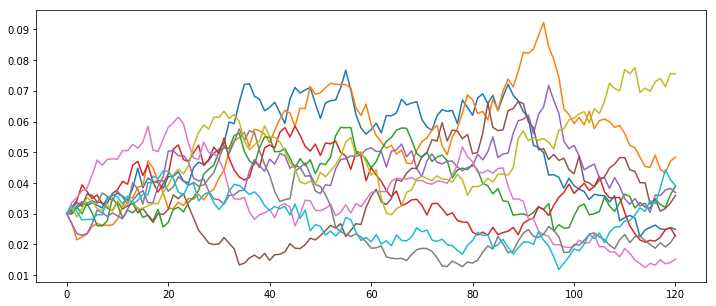

In [24]:
cir(n_scenarios=10).plot(legend=False, figsize=(12,5))

In [10]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,5))

import ipywidgets as widgets
from IPython.display import display
    
controls = widgets.interactive(show_cir,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

## Generating the random price evolution of a Zero-Coupon Bond

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$


In [25]:
import math
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices


In [26]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

Now that we can generate randomly evolving interest rates and bond prices we can add the new code for `cir` to the toolkit.

Assume our liabilities are to pay one dollar in 10 years time. Clearly, the liability is perfectly matched by the price of a zero coupon bond that matures in 10 years. Therefore, this is perfectly matched by buying a zero coupon bond. 

In [13]:
# my starting asset value today aka cash in hand
a_0 = 0.75
# simulate the next 10 years
rates, bond_prices = erk.cir(r_0=0.03, b=0.03, n_scenarios=10)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = erk.pv(pd.Series(data=[1], index=[10]), 0.03)
# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest
av_cash = a_0*(rates/12+1).cumprod()

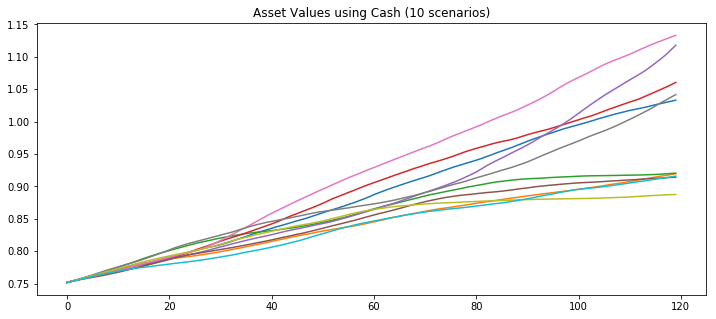

In [14]:
av_cash.plot(title='Asset Values using Cash (10 scenarios)', legend=False, figsize=(12,5))

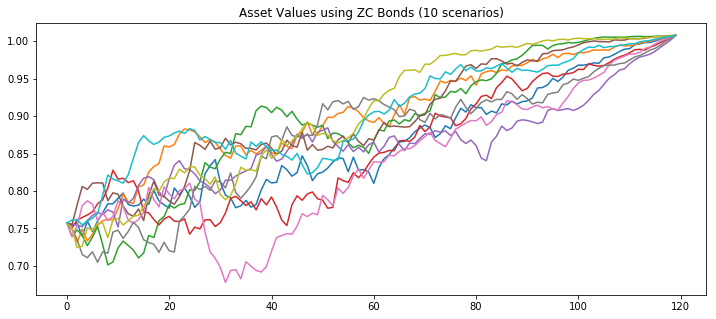

In [15]:
av_zc_bonds.plot(title='Asset Values using ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

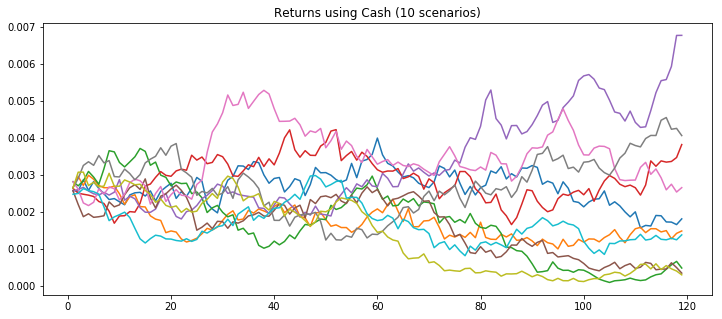

In [16]:
av_cash.pct_change().plot(title='Returns using Cash (10 scenarios)', legend=False, figsize=(12,5))

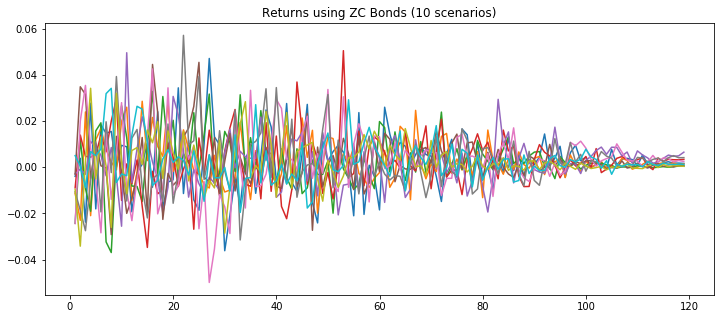

In [17]:
av_zc_bonds.pct_change().plot(title='Returns using ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

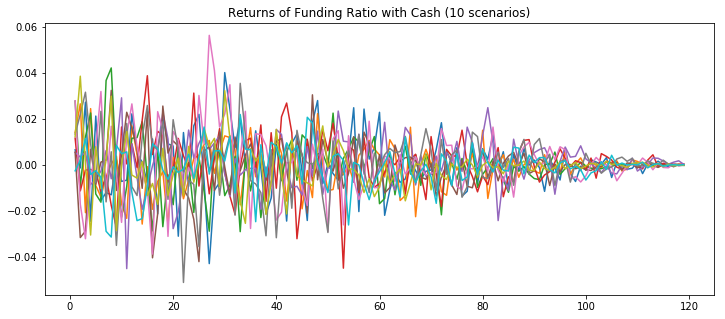

In [18]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

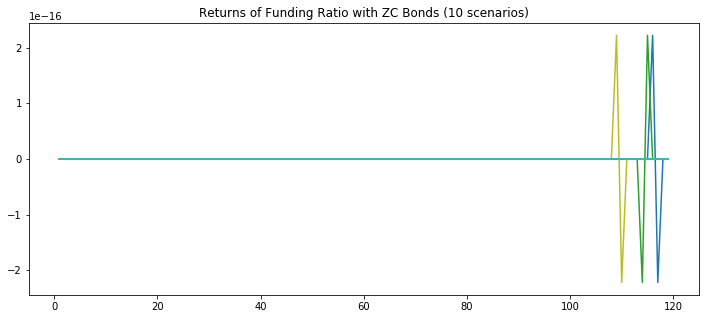

In [19]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

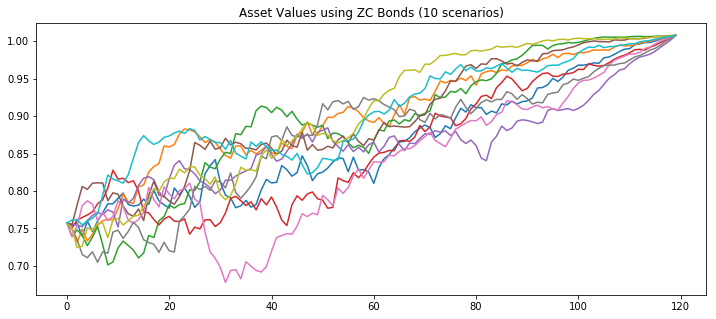

In [20]:
av_zc_bonds.plot(title='Asset Values using ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

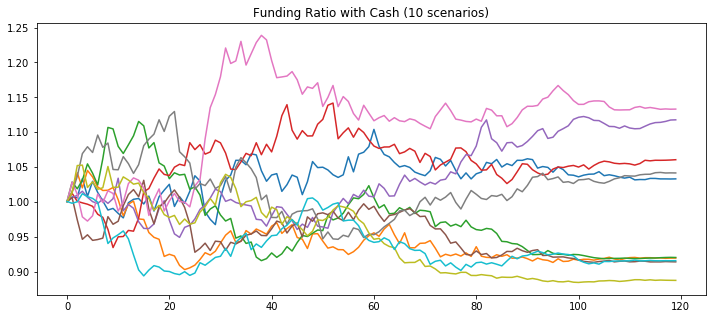

In [21]:
(av_cash/liabilities).plot(title='Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

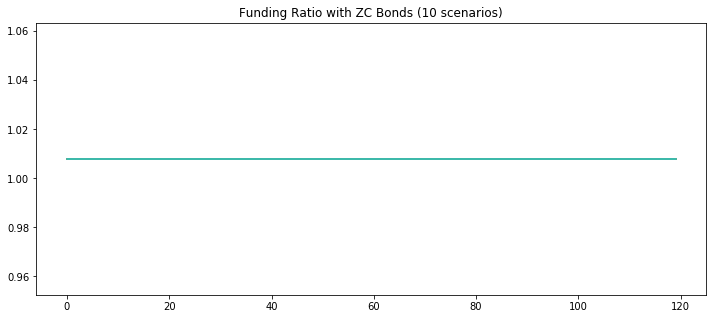

In [22]:
(av_zc_bonds/liabilities).plot(title='Funding Ratio with ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

### Terminal Funding Ratios

We can look at this in terms of Terminal Funding Ratios. Let's repeat this with a large number of simulations:

In [25]:
# my starting asset value today aka cash in hand
a_0 = 0.75
# simulate the next 10 years
rates, bond_prices = erk.cir(r_0=0.03, b=0.03, n_scenarios=10000)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = erk.pv(pd.Series(data=[1], index=[10]), 0.03)
# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest over time
av_cash = a_0*(rates/12+1).cumprod()

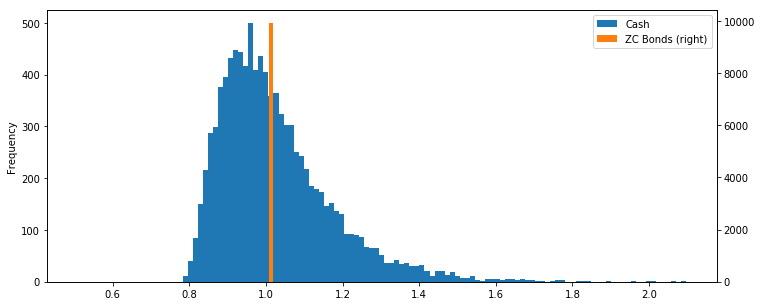

In [26]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="Cash", figsize=(12,5), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax,label="ZC Bonds", bins=100, secondary_y=True, legend=True)

### Conclusion

As you can see, hedging a future liability with cash or even cash-like instruments can be very risky. Although Zero Coupon Bonds are nominally risky and can see a great deal of price fluctuation, they vary in price in tandem with the liabilities, resulting in a much better hedge.

Of course, this makes two convenient assumptions that are often not true in practice. First, it assumes that zero coupon bonds with the perfect maturities are always available, and second, it assumes that you have the intial assets to be able to afford the hedge.

We shall try and address these in future sections. We address the first by holding a portfolio of non zero coupon bonds that will behave like a zero coupon bond in the sense that it can be liquidated at a particular maturity for an amount that is immunized against changes in interest rates. We'll address the second issue by introducing a second building block to deliver the higher performance to try and close the gap between your current assets and the upside target.